Imports and settings when working on google colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/github_projects/protein_structure_prediction

## __proteinSSpredictor__

#### This projects constitutes a final project for Data Science Bootcamp organised by Sages and aims at providing a deep-learning-based approach to predict secondary structure of the protein based on its primary sequence of the amino acids.

## __Table of contents__
#### 1. Abstract
#### 2. Source of raw sequences
#### 3. Curation of the dataset
#### 4. Prerequisites
#### 5. Raw data processing
#### 6. Exploration of preprocessed dataset for modeling
#### 7. Sequences representation for modeling
#### 8. Building a model
#### 9. Where is the model making errors?
#### 10. Summary
#### 11. References

## __1. Abstract__

#### With current development of next generation sequencing (NGS) techniques, the number of protein sequences is rapidly growing nowadays. On the other hand, experimental determination of protein structures either using X-ray crystallography, nuclear magnetic resonans (NMR) or other techniques is extremely costly, time-consuming and requires significant labour of experts in the field. This results in a huge disproportion between available protein sequences and structures available in biological databases as shown on Figure 1. 

 <img src="https://res.cloudinary.com/dnastar/image/upload/f_auto,q_auto/w_790,h_466,c_scale/v1595358297/2020-07-21_12-08-59_mwu1cj.jpg" width="500" />
 Figure 1. Increase of the protein structures and sequences in biological databases (1)
. 

#### Increasing availability of powerfull hardware, improvement of algorithms and software open the opportunity of the protein structure prediction computationally which allows avoiding costly experimental determination of the structures. The ultimate goal of the structure prediction is to predict the 3D-structure of the protein or even the quaternary structure which considers prediction of structures of multi-chain complexes (2). Although the prediction of secondary structure represents only part of the entire structure prediction process, it constitutes a vital element of the process and due to significantly lower complexity of the problem compared to 3D structure or quaternary structure prediciton, represent a perfect challange for training.

#### The goal of this project is to propose a neural network-based approach for secondary structure prediction from sequence using ProtVec embeddings (3). 

## __2. Source of raw sequences__

#### Preparation of the updated dataset analogous to reference (4)

#### Following steps from (5) the secondary structure data was downloaded by

`DATE_STAMP=$(date  +'%Y-%m-%d')
wget https://cdn.rcsb.org/etl/kabschSander/ss.txt.gz -O ${DATE_TAMP}-ss.txt.gz`

#### Further, data was transformed to csv file analogously to (5) using self-implemented method (see below for more details).

## __3. Curation of the sequence dataset__ 

#### Further, recent PISCES data with removed peptides with high sequence similarity was downloaded from (6)

#### Selected precompiled CulledPDB for further modeling was generated with following criteria:

- percentage identity cutoff: 30%
- the resolution cutoff:      2.0 Å
- the R-factor cutoff:        0.25
- date of generation:         2021/07/02
- the number of sequences:    10870


## __4. Prerequisites__

#### __Standard imports__

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Bidirectional, Conv1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

#### __Custom imports__

In [2]:
from tools import process_raw_data
from tools import visualizer
from tools import prepare_for_modeling
from tools import analizer

## __5. Raw data processing__
#### At this point the raw sequences were converted to CSV file, translated to 3 letters representation, and combined with culledPDB list with reduced sequence identity to improve the model quality

In [3]:
processing = process_raw_data.Sequences()

In [4]:
%time sequences_df = processing.process_raw_sequences('../data/2021-07-09-ss.txt.gz')

processed 477153 sequences
CPU times: user 10.7 s, sys: 329 ms, total: 11.1 s
Wall time: 11.6 s


In [5]:
#optional for faster processing (load already preprocessed data):
# sequences_df = pd.read_csv('../data/2021-07-09-ss.csv')

#### The set of raw sequences before processing with CulledPDB dataset contains 477154 and includes information about the sequence PDB ID code, protein chain and its primary sequence together with the secondary structure sequence

In [6]:
sequences_df.shape

(477154, 4)

In [7]:
sequences_df.head()

,pdb_id,chain,sequence,secondary_struct
0,101M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,CCCCHHHHHHHHHHHHHHGGGHHHHHHHHHHHHHHHCGGGGGGCTT...
1,102L,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...,CCHHHHHHHHHCCEEEEEECTTSCEEEETTEEEESSSCTTTHHHHH...
2,102M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,CCCCHHHHHHHHHHHHHHGGGHHHHHHHHHHHHHHHCGGGGGGCTT...
3,103L,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...,CCHHHHHHHHHCCEEEEEECTTSCEEEETTEECCCCCCCCCHHHHH...
4,103M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,CCCCHHHHHHHHHHHHHHGGGHHHHHHHHHHHHHHHCGGGGGGCTT...


In [8]:
pisces_df = processing.clean_pisces(pisces_file='../data/cullpdb_pc30_res2.0_R0.25_d2021_07_02_chains10870.gz')

In [9]:
pisces_df.head()

,length,source,resolution,R_value,R_free,pdb_id,chain
0,108,XRAY,2.0,0.21,0.25,1A1X,A
1,148,XRAY,1.8,0.19,0.24,1A3A,A
2,163,XRAY,1.8,0.21,0.30,1A73,A
3,226,XRAY,1.9,0.19,0.22,1A8L,A
4,1073,XRAY,1.8,0.19,1.00,1A9X,C


#### The culledPDB set containts 10870 items (PDB databases records filtered by the resolution, R-value and the 30% sequence identity). It contains information about protein PDB ID code, protein chain, method used for its determination, R-value, R-value free and the length of the sequence.

In [10]:
pisces_df.shape

(10870, 7)

In [11]:
combined_df = processing.combine_pdb_pisces(sequences_df=sequences_df, pisces_df=pisces_df)

In [12]:
combined_df.head()

,pdb_id,chain,sequence,secondary_struct,length,source,resolution,R_value,R_free
0,1A1X,A,GSAGEDVGAPPDHLWVHQEGIYRDEYQRTWVAVVEEETSFLRARVQ...,CCCCCCCCCCCSEEEEEETTEEEETTSCEEEEEEEECSSCEEEEEE...,108,XRAY,2.0,0.21,0.25
1,1A3A,A,MANLFKLGAENIFLGRKAATKEEAIRFAGEQLVKGGYVEPEYVQAM...,CCCCCCCCGGGEECSCCCSSHHHHHHHHHHHHHHTTSBCTHHHHHH...,148,XRAY,1.8,0.19,0.24
2,1A73,A,MALTNAQILAVIDSWEETVGQFPVITHHVPLGGGLQGTLHCYEIPL...,CCCCHHHHHHHHHHHHHHHTTSCEEEEEEEEETTEEEEEEEEBCCS...,163,XRAY,1.8,0.21,0.30
3,1A8L,A,MGLISDADKKVIKEEFFSKMVNPVKLIVFVRKDHCQYCDQLKQLVQ...,CCSSCHHHHHHHHHHTGGGCCSCEEEEEEECSSSCTTHHHHHHHHH...,226,XRAY,1.9,0.19,0.22
4,1A9X,F,IKSALLVLEDGTQFHGRAIGATGSAVGEVVFNTSMTGYQEILTDPS...,CCEEEEEETTCCEEEEEECSCSEEEEEEEEEECCSSCHHHHHTCGG...,379,XRAY,1.8,0.19,1.00


In [13]:
combined_df.shape

(10186, 9)

#### While intersecting raw sequences and culledPDB dataset by protein PDB ID codes and chains, I obtained slightly smaller set (10186) in then the original culledPDB (10870) due to some mismatches in the chain IDs

In [14]:
print(sorted(pisces_df.chain.unique()))
print(f'amount of unique chain IDs in PISCES dataset: {len(pisces_df.chain.unique())}')

['1', '2', '3', '4', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
amount of unique chain IDs in PISCES dataset: 30


In [15]:
print(sorted(sequences_df.chain.unique()))
print(f'amount of unique chain IDs in dataset of raw sequences: {len(sequences_df.chain.unique())}')

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
amount of unique chain IDs in dataset of raw sequences: 36


#### As the protein secondary structure can be represented in the extended form containing 8 secondary structure types (Q8) and simplified, containing only 3 secondary structure types (Q3), I created new column with the simplified version for modeling

Q8: Q3

__helices__ G, H, I: H

__sheet__ B, E: E

__coil__ T, S, C: C

#### Additionally, I got rid of the remaining columns and keep just PDB ID code, sequence, extended (Q8) secondary structure representation and simplified (Q3) representation as pdb_id, seq, sst_q8 and sst_q3, respectively:

In [16]:
processed_sequeces = processing.generate_seq_q8_q3_representation(combined_df)

In [17]:
processed_sequeces

,pdb_id,seq,sst_q8,sst_q3
0,1A1X,GSAGEDVGAPPDHLWVHQEGIYRDEYQRTWVAVVEEETSFLRARVQ...,CCCCCCCCCCCSEEEEEETTEEEETTSCEEEEEEEECSSCEEEEEE...,CCCCCCCCCCCCEEEEEECCEEEECCCCEEEEEEEECCCCEEEEEE...
1,1A3A,MANLFKLGAENIFLGRKAATKEEAIRFAGEQLVKGGYVEPEYVQAM...,CCCCCCCCGGGEECSCCCSSHHHHHHHHHHHHHHTTSBCTHHHHHH...,CCCCCCCCHHHEECCCCCCCHHHHHHHHHHHHHHCCCECCHHHHHH...
2,1A73,MALTNAQILAVIDSWEETVGQFPVITHHVPLGGGLQGTLHCYEIPL...,CCCCHHHHHHHHHHHHHHHTTSCEEEEEEEEETTEEEEEEEEBCCS...,CCCCHHHHHHHHHHHHHHHCCCCEEEEEEEEECCEEEEEEEEECCC...
3,1A8L,MGLISDADKKVIKEEFFSKMVNPVKLIVFVRKDHCQYCDQLKQLVQ...,CCSSCHHHHHHHHHHTGGGCCSCEEEEEEECSSSCTTHHHHHHHHH...,CCCCCHHHHHHHHHHCHHHCCCCEEEEEEECCCCCCCHHHHHHHHH...
4,1A9X,IKSALLVLEDGTQFHGRAIGATGSAVGEVVFNTSMTGYQEILTDPS...,CCEEEEEETTCCEEEEEECSCSEEEEEEEEEECCSSCHHHHHTCGG...,CCEEEEEECCCCEEEEEECCCCEEEEEEEEEECCCCCHHHHHCCHH...
...,...,...,...,...
10181,7BU2,MSMIKSYAAKEAGGELEVYEYDPGELRPQDVEVQVDYCGICHSDLS...,CCCEEEEEESSTTCCEEEEEECCCSCCTTEEEEEEEEEEECHHHHH...,CCCEEEEEECCCCCCEEEEEECCCCCCCCEEEEEEEEEEECHHHHH...
10182,7BVD,MQTTANHSSRSTQTGTRAHGAALAETTSREDFRALATEHRVVPVIR...,CCCCCCCCCCCCCCCCCCCCCCTTCCCCHHHHHHHHTTCSEEEEEE...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCHHHHHHHHCCCCEEEEEE...
10183,7BYW,MRGSHHHHHHSGQRMGMVIGIKPEHIDEYKRLHAAVWPAVLARLAE...,CCCCCCCCCCCCCEEEEEEEECGGGHHHHHHHHTTCCHHHHHHHHH...,CCCCCCCCCCCCCEEEEEEEECHHHHHHHHHHHCCCCHHHHHHHHH...
10184,7ODC,MSSFTKDEFDCHILDEGFTAKDILDQKINEVSSSDDKDAFYVADLG...,CCEEEETTEEEEEECSSCCHHHHHHHHHCCCCCCCCCCCEEEEEHH...,CCEEEECCEEEEEECCCCCHHHHHHHHHCCCCCCCCCCCEEEEEHH...


#### Then, I have checked whether all representations of each protein in my dataset have complementary length

In [18]:
test_df = pd.DataFrame()
test_df['seq_len'] = [len(x) for x in processed_sequeces.seq]
test_df['sst_q8_len'] = [len(x) for x in processed_sequeces.sst_q8]
test_df['sst_q3_len'] = [len(x) for x in processed_sequeces.sst_q3]

In [19]:
processed_sequeces['pdb_id'][(test_df.seq_len != test_df.sst_q8_len) | (test_df.seq_len != test_df.sst_q3_len)]

Series([], Name: pdb_id, dtype: object)

In [20]:
processed_sequeces = processed_sequeces.assign(length=test_df.seq_len)

#### There were no mismatches between representations, hence I proceeded further. Sequences can potentially contain non-standard amino acids (https://www.samformat.info/IUPAC-ambiguity-codes).

#### Standard set includes 20 types: 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'

#### Non-standard amino acids may include: 'B', 'J', 'O', 'U', 'Z' and 'X', where the last represents unspecified or unknown (potentially missing type). I have inspected the dataset from that perspective.

In [21]:
contains_nonstandard_aa, nonstandard_types = analizer.detect_nonstandard_aa(processed_sequeces.seq)
processed_sequeces = processed_sequeces.assign(contains_nonstandard_aa = contains_nonstandard_aa)
processed_sequeces = processed_sequeces.assign(nonstandard_types = nonstandard_types)

In [22]:
processed_sequeces[processed_sequeces.contains_nonstandard_aa > 0].shape

(71, 7)

#### I observed, that 71 sequences contain nonstandard amino amids and had a closer look at those which have more of them, focusing especially on the unknown (X) 

In [23]:
processed_sequeces[processed_sequeces.contains_nonstandard_aa > 1]

,pdb_id,seq,sst_q8,sst_q3,length,contains_nonstandard_aa,nonstandard_types
906,1SN9,XYRIPSYDFADELAKLLRQAAGX,CCEETTEEHHHHHHHHHHHHTCC,CCEECCEEHHHHHHHHHHHHCCC,23,2,XX
2135,2O5G,XARRKWQKTGHAVRAIGRLSX,CCHHHHHHHHHHHHHHHHHCC,CCHHHHHHHHHHHHHHHHHCC,21,2,XX
2140,2O6N,XAEIEQAKKEIAYLIKKAKEEILEEIKKAKQEIAX,CCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCC,CCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCC,35,2,XX
2516,2RKZ,XETLTGQYDKNLVTTVEEEYDSX,CCCEEECSCTTSCCEEEEECCCC,CCCEEECCCCCCCCEEEEECCCC,23,2,XX
2801,2XSK,MGSSQITFNTTQQGDMYTIIPEVTLTQSULURVQILSLREGSSGQS...,CCCCEEEEEEEEETTEEEEEEEEECSSCEEEEEEEEEEEECSSCEE...,CCCCEEEEEEEEECCEEEEEEEEECCCCEEEEEEEEEEEECCCCEE...,110,2,UU
3210,3CAL,XKGIVTGAVSDHTTVEDTKX,CCCCEEECCSSCEEEECCCC,CCCCEEECCCCCEEEECCCC,20,2,XX
3213,3CAY,XAXAEAAEKAAKYAAEAAEKAAKAXAX,CCHHHHHHHHHHHHHHHHHHHHHHHCC,CCHHHHHHHHHHHHHHHHHHHHHHHCC,27,4,XXXX
4431,3O3Y,XTTWEAWDXAIAEYAXRIEXLIXAAQEQQEKNEXALXELX,CCCTTTHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHSCCC,CCCCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCCCC,40,8,XXXXXXXX
4933,3U5S,SMRTQQKRDTKFREDUPPDREELGRHSWAVLHTLAAYYPDLPTPEQ...,CCCCSCGGGTCCCSSSCCCHHHHHHHHHHHHHHHHHTSCSSCCHHH...,CCCCCCHHHCCCCCCCCCCHHHHHHHHHHHHHHHHHCCCCCCCHHH...,126,6,UUUUUU
5083,3W19,XNNLLRAIEAQQHLLQLTVWGIKQLQARILAVERYLKDQX,CCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCC,CCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCC,40,2,XX


In [24]:
processed_sequeces[processed_sequeces.contains_nonstandard_aa > 4]

,pdb_id,seq,sst_q8,sst_q3,length,contains_nonstandard_aa,nonstandard_types
4431,3O3Y,XTTWEAWDXAIAEYAXRIEXLIXAAQEQQEKNEXALXELX,CCCTTTHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHSCCC,CCCCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCCCC,40,8,XXXXXXXX
4933,3U5S,SMRTQQKRDTKFREDUPPDREELGRHSWAVLHTLAAYYPDLPTPEQ...,CCCCSCGGGTCCCSSSCCCHHHHHHHHHHHHHHHHHTSCSSCCHHH...,CCCCCCHHHCCCCCCCCCCHHHHHHHHHHHHHHHHHCCCCCCCHHH...,126,6,UUUUUU
7112,4Z0W,XAPAPFVPAAXAVXLAXLAALXG,CCCTTTGGGGGGGGGGGGGGGCC,CCCCCCHHHHHHHHHHHHHHHCC,23,5,XXXXX
9174,6FHN,GVVQSVNVSQAGYSSNDFKTATVTASDKLSDTSYQILQGTTVIATG...,CCEEEEECCTTCEETTSCCEEEEEESSCCSCCEEEEESSSSEEEEE...,CCEEEEECCCCCEECCCCCEEEEEECCCCCCCEEEEECCCCEEEEE...,1009,33,XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
9259,6GME,XXXXXXXXXXXXXXXXXXINFKQAEKMMETMDQGDVIIRPSSKGEN...,CCCCCCCCCCCCCEEECCCCHHHHHHHHHHSCTTCEEEEECSSCTT...,CCCCCCCCCCCCCEEECCCCHHHHHHHHHHCCCCCEEEEECCCCCC...,201,18,XXXXXXXXXXXXXXXXXX


In [25]:
processed_sequeces.seq[processed_sequeces.pdb_id == '6FHN'].values

array(['GVVQSVNVSQAGYSSNDFKTATVTASDKLSDTSYQILQGTTVIATGTMKDEGYVWGKYVYSIDFSSVTATGTNFTIRSNGVSSYTFPIQTNMWNEYKDEMTAFYRLLRTTDTFAAYPAGYSNIAPSNKILHPDSFLDDAFSPDRTTHYDLTGGWFDAGDYGKYGGNQWVQGNIAISYLRHASSAAVNFDKDTNGIPDLVDEAIFGSQYLVKFANQLGGAIHNILRKGGFVLPHKVTDNVPGNTDDRALEAVEAVGGSGKSSGSLAATARAIRTAIAGGKVAANKVAQLQTLANEFQAAAIIFYNYTLTHQSGNHGSYGTMNNGGIANPLLWAEVQLYLLTGDAAYKTQAQTRINAINEAYVSSTNYWDMHPIALAEFYPVADSAIKTKIQSILKHQAYYFITLMDETPYGVLNQFGNFGVNEPHASYMADLLRYYELFNDPVALRAAKKALYWIVGNNPWNISWVSGVGSNFTDFLHTRLDEEAYSQTNTGVVLPGAMVSGPNIKDPNNKLSSSPWYEDKPIWADDTNQWRYNEYSVSIQTGLFYTIMGLSALGGNASTGGAEPVKLPITWPIIGDYVTGDVTVFAQPEGSLSNVSANGIVLSPSDGVYTTTVSTSADAPYTERKVQIKGTDDSGFTTYSNTHFTVAPALPDPSHPLLFDDFNQKGIWGSQKLDWVNWYNQNGGTASYTRTTVDTRTVGKFAHTPAATTSKAKFQPWKYNANLNGYRYLNFTMKNPGYPNTKIRIAANDGTKSVNLTSGEVAISSTWTTYQYDLNLHPTLNKSNVLIEVWLSNPTAGAYGEILIDEISAVNTNSGTAPTLSATGVNASIGNQSTVFTYTATYTDANNQAPFDVQVVIDGVIRSMTAADPTDTTYSDGRVYTYATTLPVGTHKFYFRTTDTTTNFVSTSVQTGPTVIRNKLEAEVLSINLTNYTHAVKDNADASGGKYRLFNGRQANDYIEYAVNVPKAGTYQVSAXXXXXXXXXXXXXXXXX

In [26]:
processed_sequeces.seq[processed_sequeces.pdb_id == '6GME'].values

array(['XXXXXXXXXXXXXXXXXXINFKQAEKMMETMDQGDVIIRPSSKGENHLTVTWKVSDGIYQHVDVREEGKENAFSLGATLWINSEEFEDLDEIVARYVQPMASFARDLLNHKYYQDCSGGDRKKLEELLIKTKKEKPTFIPYFICACKELPGKFLLGYQPRGKPRIEYVTVTPEGFRYRGQIFPTVNGLFRWFKDHYQDPVP'],
      dtype=object)

#### There were two sequences (6FHN and 6GME) in the dataset which contained significant amount of the unknown residues at the beginning or end, which most likely is conditioned by high mobility of these regions preventing correct assignment of the amino acid type, which affects the quality of the DSSP secondary structure prediciton, so I have removed these two sequences from the dataset, as they were most likely of lower quality besides their relatively high resolution as filtered in CulledPDB from PISCES.

In [27]:
processed_sequeces = processed_sequeces.drop(processed_sequeces[processed_sequeces.contains_nonstandard_aa > 10].index)

## __6. Exploration of preprocessed dataset for modeling__

In [28]:
processed_sequeces.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10184 entries, 0 to 10185
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   pdb_id                   10184 non-null  object
 1   seq                      10184 non-null  object
 2   sst_q8                   10184 non-null  object
 3   sst_q3                   10184 non-null  object
 4   length                   10184 non-null  int64 
 5   contains_nonstandard_aa  10184 non-null  int64 
 6   nonstandard_types        10184 non-null  object
dtypes: int64(2), object(5)
memory usage: 636.5+ KB


#### Prepared dataset does not contain any missing records and can be used for convertion for modeling

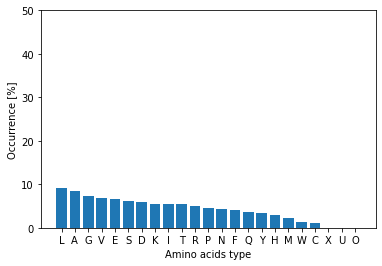

In [29]:
visualizer.visualize_occurrence(feature_series=processed_sequeces.seq, xlabel='Amino acids type').show()

#### Three most frequently occuring amino acids in the dataset are Leucine (L), Alanine (A) and Glycine (G).

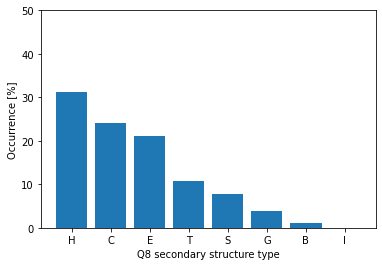

In [30]:
visualizer.visualize_occurrence(feature_series=processed_sequeces.sst_q8, xlabel='Q8 secondary structure type').show()

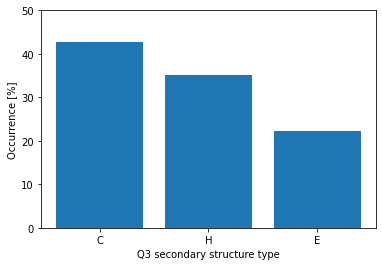

In [31]:
visualizer.visualize_occurrence(feature_series=processed_sequeces.sst_q3, xlabel='Q3 secondary structure type').show()

## __7. Sequences representation for modeling__

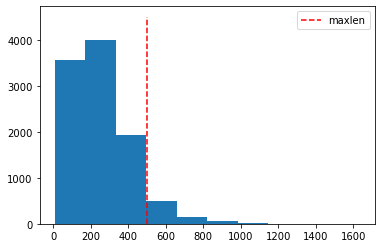

In [32]:
processed_sequeces.length.hist()
plt.vlines(x=500, ymin=0, ymax=4500, colors='red', linestyles='--', label='maxlen')
plt.legend()
plt.grid(None)
plt.show()

#### Most of the sequences in prepared dataset did not exceed the length of 500 amino acids, hence I have limited the max length to 500 and unify the length of the samples by padding accordingly

In [33]:
maxlen = 500

#### Then sequences were prepared for modeling. As an ulimate goal was to use a so called ProtVec embedding obtained on the large dataset for DNA, RNA and Protein sequences (3), the sequences were represented in the same form of ngrams consisting of 3 consecutive amino acids in the sequence as it was shown to represent the protein sequence well for deep learning applications (7).  

In [34]:
input_sequences = prepare_for_modeling.convert_to_ngrams(sequences=processed_sequeces.seq, n=3)
X_seq, seq_index = prepare_for_modeling.tokenize_inputs(input_sequences=input_sequences, maxlen=maxlen)
y_sst8, sst8_index = prepare_for_modeling.tokenize_target(target_sst=processed_sequeces.sst_q8, maxlen=maxlen)
y_sst3, sst3_index = prepare_for_modeling.tokenize_target(target_sst=processed_sequeces.sst_q3, maxlen=maxlen)

In [35]:
X_seq.shape, y_sst8.shape, y_sst3.shape

((10184, 500), (10184, 500, 9), (10184, 500, 4))

#### 3 state prediction dataset split 

In [36]:
X_train, X_test, y_train_q3, y_test_q3 = train_test_split(X_seq, y_sst3, test_size=0.2, random_state=42)

In [37]:
X_train.shape, X_test.shape, y_train_q3.shape, y_test_q3.shape

((8147, 500), (2037, 500), (8147, 500, 4), (2037, 500, 4))

In [38]:
# dimensions for simple embeddings
embedding_dims = 500

In [39]:
n_words = len(seq_index) + 1  # including the padding
n_tags = len(sst3_index) + 1  # including the padding
print(n_words, n_tags)

8586 4


#### Preparation of the above mentioned ProtVec embeddings from external source:


In [40]:
protvec_shape, protvec_embeddings = prepare_for_modeling.parse_protvec_embeddings('../data/uniref_3M.vec')

In [41]:
protvec_shape

(10180, 1000)

#### Preparation of the embedding matrix using ProtVec embeddings weights and unique n_grams from my sequences:

In [42]:
embedding_matrix = np.zeros((len(seq_index) + 1, protvec_shape[1]))
for word, i in seq_index.items():
    embedding_vector = protvec_embeddings.get(word.upper())
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [43]:
embedding_matrix.shape

(8586, 1000)

## __8. Building a model__

#### Q3 protein secondary structure prediction using various models 

In [46]:
early_stopping = EarlyStopping(monitor='val_categorical_accuracy',
                              patience=10,
                              restore_best_weights=True)

In [49]:
# LSTM + simple embedding
model1 = Sequential()
model1.add(Embedding(input_shape=(maxlen,), 
                     input_dim=n_words, 
                     output_dim=100, 
                     input_length=maxlen))
model1.add(LSTM(units=64,
                activation='tanh', 
                recurrent_activation='sigmoid', 
                return_sequences=True))
model1.add(TimeDistributed(Dense(n_tags, 
                                 activation="softmax")))
model1.summary()
model1.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["categorical_accuracy"])
model1_history = model1.fit(X_train,
                            y_train_q3,
                            validation_split=0.2,
                            callbacks=[early_stopping], 
                            epochs=100)
model1.save('../models/model1_lstm_x1.h5')
model1.evaluate(X_test, y_test_q3) 
model1_hist_df = pd.DataFrame(model1_history.history)
with open('../models/model1_lstm_x1_history.csv', 'w') as out:
  model1_hist_df.to_csv(out)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 100)          858600    
_________________________________________________________________
lstm (LSTM)                  (None, 500, 64)           42240     
_________________________________________________________________
time_distributed (TimeDistri (None, 500, 4)            260       
Total params: 901,100
Trainable params: 901,100
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
204/204 [==============================] - 10s 36ms/step - loss: 0.5442 - categorical_accuracy: 0.7497 - val_loss: 0.4185 - val_categorical_accuracy: 0.8126
Epoch 2/100
204/204 [==============================] - 7s 34ms/step - loss: 0.4151 - categorical_accuracy: 0.8147 - val_loss: 0.4083 - val_categorical_accuracy: 0.8174
Epoch 3/100
204/204 [======================

In [50]:
# 2x LSTM + simple embedding
model2 = Sequential()
model2.add(Embedding(input_shape=(maxlen,), 
                     input_dim=n_words, 
                     output_dim=100, 
                     input_length=maxlen))
model2.add(LSTM(units=128,
                activation='tanh', 
                recurrent_activation='sigmoid', 
                return_sequences=True))
model2.add(LSTM(units=64,
                activation='tanh', 
                recurrent_activation='sigmoid', 
                return_sequences=True))
model2.add(TimeDistributed(Dense(n_tags, 
                                 activation="softmax")))
model2.summary()
model2.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["categorical_accuracy"])
model2_history = model2.fit(X_train,
                            y_train_q3,
                            validation_split=0.2,
                            callbacks=[early_stopping], 
                            epochs=100)
model2.save('../models/model2_lstm_x2.h5')
model2.evaluate(X_test, y_test_q3) 
model2_hist_df = pd.DataFrame(model2_history.history)
with open('../models/model2_lstm_x2_history.csv', 'w') as out:
  model2_hist_df.to_csv(out)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          858600    
_________________________________________________________________
lstm_1 (LSTM)                (None, 500, 128)          117248    
_________________________________________________________________
lstm_2 (LSTM)                (None, 500, 64)           49408     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 500, 4)            260       
Total params: 1,025,516
Trainable params: 1,025,516
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
204/204 [==============================] - 16s 63ms/step - loss: 0.5374 - categorical_accuracy: 0.7349 - val_loss: 0.4235 - val_categorical_accuracy: 0.8091
Epoch 2/100
204/204 [==============================] - 12s 60ms/step - lo

In [51]:
# 2x LSTM + protvec embeddings
model3 = Sequential()
model3.add(Embedding(input_dim = len(seq_index) + 1,
                     output_dim = protvec_shape[1],
                     weights=[embedding_matrix],
                     input_length=maxlen,
                     trainable=False))
model3.add(LSTM(units=128,
                activation='tanh', 
                recurrent_activation='sigmoid', 
                return_sequences=True))
model3.add(LSTM(units=64,
                activation='tanh', 
                recurrent_activation='sigmoid', 
                return_sequences=True))
model3.add(TimeDistributed(Dense(n_tags, 
                                 activation="softmax")))
model3.summary()
model3.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["categorical_accuracy"])
model3_history = model3.fit(X_train,
                            y_train_q3,
                            validation_split=0.2,
                            callbacks=[early_stopping], 
                            epochs=100)
model3.save('../models/model3_lstm_x2_protvec_embeddings.h5')
model3.evaluate(X_test, y_test_q3)
model3_hist_df = pd.DataFrame(model3_history.history)
with open('../models/model3_lstm_x2_protvec_embeddings_history.csv', 'w') as out:
  model3_hist_df.to_csv(out)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 1000)         8586000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 500, 128)          578048    
_________________________________________________________________
lstm_4 (LSTM)                (None, 500, 64)           49408     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 500, 4)            260       
Total params: 9,213,716
Trainable params: 627,716
Non-trainable params: 8,586,000
_________________________________________________________________
Epoch 1/100
204/204 [==============================] - 17s 72ms/step - loss: 0.5296 - categorical_accuracy: 0.7645 - val_loss: 0.4341 - val_categorical_accuracy: 0.8034
Epoch 2/100
204/204 [==============================] - 14s 67ms/ste

In [52]:
# 2x LSTM + 2x Dense + protvec embeddings
model4 = Sequential()
model4.add(Embedding(input_dim = len(seq_index) + 1,
                     output_dim = protvec_shape[1],
                     weights=[embedding_matrix],
                     input_length=maxlen,
                     trainable=False))
model4.add(LSTM(units=128,
                activation='tanh', 
                recurrent_activation='sigmoid', 
                return_sequences=True))
model4.add(LSTM(units=64,
                activation='tanh', 
                recurrent_activation='sigmoid', 
                return_sequences=True))
model4.add(Dense(64, activation='relu'))
model4.add(Dense(32, activation='relu'))
model4.add(TimeDistributed(Dense(n_tags, 
                                 activation="softmax")))
model4.summary()
model4.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["categorical_accuracy"])
model4_history = model4.fit(X_train,
                            y_train_q3,
                            validation_split=0.2,
                            callbacks=[early_stopping], 
                            epochs=100)
model4.save('../models/model4_lstm_x2_dense_x2_protvec_embeddings.h5')
model4.evaluate(X_test, y_test_q3)
model4_hist_df = pd.DataFrame(model4_history.history)
with open('../models/model4_lstm_x2_dense_x2_protvec_embeddings_history.csv', 'w') as out:
  model4_hist_df.to_csv(out)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 1000)         8586000   
_________________________________________________________________
lstm_5 (LSTM)                (None, 500, 128)          578048    
_________________________________________________________________
lstm_6 (LSTM)                (None, 500, 64)           49408     
_________________________________________________________________
dense_3 (Dense)              (None, 500, 64)           4160      
_________________________________________________________________
dense_4 (Dense)              (None, 500, 32)           2080      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 500, 4)            132       
Total params: 9,219,828
Trainable params: 633,828
Non-trainable params: 8,586,000
______________________________________

In [53]:
# BiLSTM + protvec embeddings
model5 = Sequential()
model5.add(Embedding(input_dim = len(seq_index) + 1,
                     output_dim = protvec_shape[1],
                     weights=[embedding_matrix],
                     input_length=maxlen,
                     trainable=False))
model5.add(Bidirectional(LSTM(units=128,
                activation='tanh', 
                recurrent_activation='sigmoid', 
                return_sequences=True)))
model5.add(TimeDistributed(Dense(n_tags, 
                                 activation="softmax")))
model5.summary()
model5.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["categorical_accuracy"])
model5_history = model5.fit(X_train,
                            y_train_q3,
                            validation_split=0.2,
                            callbacks=[early_stopping], 
                            epochs=100)
model5.save('../models/model5_bilstm_protvec_embeddings.h5')
model5.evaluate(X_test, y_test_q3)
model5_hist_df = pd.DataFrame(model5_history.history)
with open('../models/model5_bilstm_protvec_embeddings_history.csv', 'w') as out:
  model5_hist_df.to_csv(out)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 1000)         8586000   
_________________________________________________________________
bidirectional (Bidirectional (None, 500, 256)          1156096   
_________________________________________________________________
time_distributed_4 (TimeDist (None, 500, 4)            1028      
Total params: 9,743,124
Trainable params: 1,157,124
Non-trainable params: 8,586,000
_________________________________________________________________
Epoch 1/100
204/204 [==============================] - 20s 86ms/step - loss: 0.4793 - categorical_accuracy: 0.7956 - val_loss: 0.4028 - val_categorical_accuracy: 0.8200
Epoch 2/100
204/204 [==============================] - 17s 83ms/step - loss: 0.4008 - categorical_accuracy: 0.8224 - val_loss: 0.3843 - val_categorical_accuracy: 0.8303
Epoch 3/100
204/204 [=======

In [54]:
# 2x BiLSTM + protvec embeddings
model6 = Sequential()
model6.add(Embedding(input_dim = len(seq_index) + 1,
                     output_dim = protvec_shape[1],
                     weights=[embedding_matrix],
                     input_length=maxlen,
                     trainable=False))
model6.add(Bidirectional(LSTM(units=128,
                activation='tanh', 
                recurrent_activation='sigmoid', 
                return_sequences=True)))
model6.add(Bidirectional(LSTM(units=64,
                activation='tanh', 
                recurrent_activation='sigmoid', 
                return_sequences=True)))
model6.add(TimeDistributed(Dense(n_tags, 
                                 activation="softmax")))
model6.summary()
model6.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["categorical_accuracy"])
model6_history = model6.fit(X_train,
                            y_train_q3,
                            validation_split=0.2,
                            callbacks=[early_stopping], 
                            epochs=100)
model6.save('../models/model6_bilstm_x2_protvec_embeddings.h5')
model6.evaluate(X_test, y_test_q3)
model6_hist_df = pd.DataFrame(model6_history.history)
with open('../models/model6_bilstm_x2_protvec_embeddings_history.csv', 'w') as out:
  model6_hist_df.to_csv(out)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 1000)         8586000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 500, 256)          1156096   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 500, 128)          164352    
_________________________________________________________________
time_distributed_5 (TimeDist (None, 500, 4)            516       
Total params: 9,906,964
Trainable params: 1,320,964
Non-trainable params: 8,586,000
_________________________________________________________________
Epoch 1/100
204/204 [==============================] - 30s 121ms/step - loss: 0.4791 - categorical_accuracy: 0.7874 - val_loss: 0.4096 - val_categorical_accuracy: 0.8162
Epoch 2/100
204/204 [==============================] - 23s 115ms

In [112]:
# 2x BiLSTM + 2x Dense + protvec embeddings
model7 = Sequential()
model7.add(Embedding(input_dim = len(seq_index) + 1,
                     output_dim = protvec_shape[1],
                     weights=[embedding_matrix],
                     input_length=maxlen,
                     trainable=False))
model7.add(Bidirectional(LSTM(units=128,
                activation='tanh', 
                recurrent_activation='sigmoid', 
                return_sequences=True)))
model7.add(Bidirectional(LSTM(units=64,
                activation='tanh', 
                recurrent_activation='sigmoid', 
                return_sequences=True)))
model7.add(Dense(64, activation='relu'))
model7.add(Dense(32, activation='relu'))
model7.add(TimeDistributed(Dense(n_tags, 
                                 activation="softmax")))
model7.summary()
model7.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["categorical_accuracy"])
model7_history = model7.fit(X_train,
                            y_train_q3,
                            validation_split=0.2,
                            callbacks=[early_stopping], 
                            epochs=100)
model7.save('../models/model7_bilstm_x2_dense_x2_protvec_embeddings.h5')
model7.evaluate(X_test, y_test_q3)
model7_hist_df = pd.DataFrame(model7_history.history)
with open('../models/model7_bilstm_x2_dense_x2_protvec_embeddings_history.csv', 'w') as out:
  model7_hist_df.to_csv(out)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 500, 1000)         8586000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 500, 256)          1156096   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 500, 128)          164352    
_________________________________________________________________
dense_8 (Dense)              (None, 500, 64)           8256      
_________________________________________________________________
dense_9 (Dense)              (None, 500, 32)           2080      
_________________________________________________________________
time_distributed_6 (TimeDist (None, 500, 4)            132       
Total params: 9,916,916
Trainable params: 1,330,916
Non-trainable params: 8,586,000
____________________________________

In [113]:
# Conv1d + 2x BiLSTM + 2x Dense + protvec embeddings
model8 = Sequential()
model8.add(Embedding(input_dim = len(seq_index) + 1,
                     output_dim = protvec_shape[1],
                     weights=[embedding_matrix],
                     input_length=maxlen,
                     trainable=False))
model8.add(Conv1D(256, 3, activation='relu', 
                  padding='same',
                  input_shape=(len(seq_index) + 1,protvec_shape[1])))
model8.add(Bidirectional(LSTM(units=128,
                activation='tanh', 
                recurrent_activation='sigmoid', 
                return_sequences=True)))
model8.add(Bidirectional(LSTM(units=64,
                activation='tanh', 
                recurrent_activation='sigmoid', 
                return_sequences=True)))
model8.add(Dense(64, activation='relu'))
model8.add(Dense(32, activation='relu'))
model8.add(TimeDistributed(Dense(n_tags, 
                                 activation="softmax")))
model8.summary()
model8.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["categorical_accuracy"])
model8_history = model8.fit(X_train,
                            y_train_q3,
                            validation_split=0.2,
                            callbacks=[early_stopping], 
                            epochs=100)
model8.save('../models/model8_conv1d_bilstm_x2_dense_x2_protvec_embeddings.h5')
model8.evaluate(X_test, y_test_q3)
model8_hist_df = pd.DataFrame(model8_history.history)
with open('../models/model8_conv1d_bilstm_x2_dense_x2_protvec_embeddings_history.csv', 'w') as out:
  model8_hist_df.to_csv(out)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 500, 1000)         8586000   
_________________________________________________________________
conv1d (Conv1D)              (None, 500, 256)          768256    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 500, 256)          394240    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 500, 128)          164352    
_________________________________________________________________
dense_11 (Dense)             (None, 500, 64)           8256      
_________________________________________________________________
dense_12 (Dense)             (None, 500, 32)           2080      
_________________________________________________________________
time_distributed_7 (TimeDist (None, 500, 4)           

#### Using the best settings obtained so far (model8), another model was trained towards more difficult task which is the Q8 secondary structure predition. For this purpose train and test sets with Q8 target were prepared:

In [44]:
X_train, X_test, y_train_q8, y_test_q8 = train_test_split(X_seq, y_sst8, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train_q8.shape, y_test_q8.shape

((8147, 500), (2037, 500), (8147, 500, 9), (2037, 500, 9))

In [45]:
n_words = len(seq_index) + 1  # including the padding
n_tags = len(sst8_index) + 1  # including the padding
print(n_words, n_tags)

8586 9


In [116]:
# Conv1d + 2x BiLSTM + 2x Dense + protvec embeddings for Q8 structure prediction
model9 = Sequential()
model9.add(Embedding(input_dim = len(seq_index) + 1,
                     output_dim = protvec_shape[1],
                     weights=[embedding_matrix],
                     input_length=maxlen,
                     trainable=False))
model9.add(Conv1D(256, 3, activation='relu', 
                  padding='same',
                  input_shape=(len(seq_index) + 1,protvec_shape[1])))
model9.add(Bidirectional(LSTM(units=128,
                activation='tanh', 
                recurrent_activation='sigmoid', 
                return_sequences=True)))
model9.add(Bidirectional(LSTM(units=64,
                activation='tanh', 
                recurrent_activation='sigmoid', 
                return_sequences=True)))
model9.add(Dense(64, activation='relu'))
model9.add(Dense(32, activation='relu'))
model9.add(TimeDistributed(Dense(n_tags, 
                                 activation="softmax")))
model9.summary()
model9.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["categorical_accuracy"])
model9_history = model9.fit(X_train,
                            y_train_q8,
                            validation_split=0.2,
                            callbacks=[early_stopping], 
                            epochs=100)
model9.save('../models/model9_conv1d_bilstm_x2_dense_x2_protvec_embeddings_q8.h5')
model9.evaluate(X_test, y_test_q8)
model9_hist_df = pd.DataFrame(model9_history.history)
with open('../models/model9_conv1d_bilstm_x2_dense_x2_protvec_embeddings_q8_history.csv', 'w') as out:
  model9_hist_df.to_csv(out)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 500, 1000)         8586000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 256)          768256    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 500, 256)          394240    
_________________________________________________________________
bidirectional_8 (Bidirection (None, 500, 128)          164352    
_________________________________________________________________
dense_14 (Dense)             (None, 500, 64)           8256      
_________________________________________________________________
dense_15 (Dense)             (None, 500, 32)           2080      
_________________________________________________________________
time_distributed_8 (TimeDist (None, 500, 9)           

## __9. Where is the model making errors?__

#### __Evaluation of Q3 secondary structure prediction__

In [46]:
loaded_model8 = load_model('../models/model8_conv1d_bilstm_x2_dense_x2_protvec_embeddings.h5')

In [47]:
loaded_model8.evaluate(X_test, y_test_q3)

64/64 [==============================] - 49s 741ms/step - loss: 0.3476 - categorical_accuracy: 0.8509


[0.3475867509841919, 0.8509101867675781]

#### Model reached 0.85 categorical accuracy and 0.35 loss on the test dataset for Q3 prediction

In [47]:
reversed_sst3_index = dict([(value, key) for (key, value) in sst3_index.items()])
y_test_pred_q3 = loaded_model8.predict(X_test)
sst3_model_eval_df = pd.DataFrame({'original_sst3': [''.join([reversed_sst3_index[np.argmax(x)] for x in y if np.argmax(x) != 0]) for y in y_test_q3],
                                   'predicted_sst3_test': [''.join([reversed_sst3_index[np.argmax(x)] for x in y if np.argmax(x) != 0]) for y in y_test_pred_q3]})
sst3_model_eval_df['correctly_assigned'] = analizer.compare_original_predicted(sst3_model_eval_df.predicted_sst3_test, sst3_model_eval_df.original_sst3)[0]
sst3_model_eval_df['mistakes'] = analizer.compare_original_predicted(sst3_model_eval_df.predicted_sst3_test, sst3_model_eval_df.original_sst3)[1]

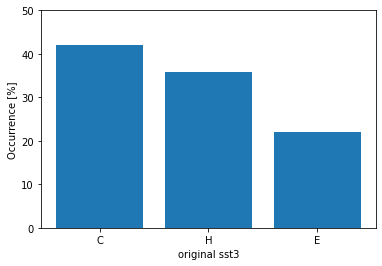

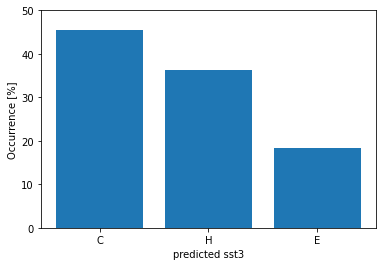

In [48]:
visualizer.visualize_occurrence(feature_series=sst3_model_eval_df.original_sst3, xlabel='original sst3').show()
visualizer.visualize_occurrence(feature_series=sst3_model_eval_df.predicted_sst3_test, xlabel='predicted sst3').show()

#### Comparison on the distribution of particular secondary structure elements indicates, that the overall trend of the prediction is maintained - highest occurance of the coils (C), followed by the helices (H) and finally extended conformations (E), which corresponds nicely with the initial exploration of the original data. Nevertheless, one can observe decreased occurance of the extended conformations in the predicted sequences (lower plot) compared to original set (upper plot), which indicates imperfections in the model.

In [49]:
sst3_model_eval_df.correctly_assigned.mean().round(2)

0.71

#### Investigaton of the corresponding original and predicted secondary structure elements in terms proper classification indicates that on average __71%__ of the positions was predicted correctly in the test set 

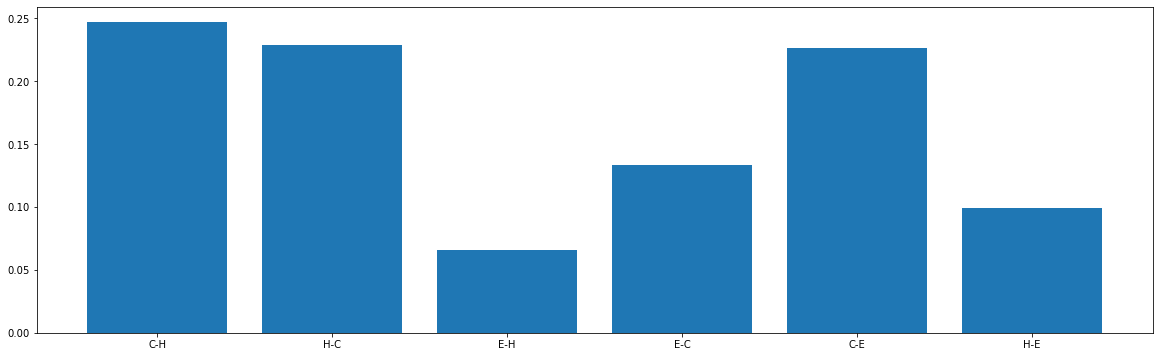

In [51]:
sst3_mistakes_summary = dict(Counter(list(itertools.chain.from_iterable(sst3_model_eval_df.mistakes.values.tolist()))))
plt.figure(figsize=(20,6))
plt.bar(x=np.arange(len(sst3_mistakes_summary)), height=[x/sum(sst3_mistakes_summary.values()) for x in sst3_mistakes_summary.values()]) 
plt.xticks(ticks=np.arange(len(sst3_mistakes_summary)), labels=sst3_mistakes_summary.keys())
plt.show()

#### Further analysis suggests that three the most frequently occuring errors in the secondary structure predictions are assignment of coil instead of helix (C-H), helix instead of coil (H-C) and coil instead of extended conformation (C-E). This explained decreased occurance of predicted E, as first two approximately balance each other, while the latter results on the gain in coil occurance which decrease the occurance of extended conformation.

##### __Q3 best predictions__

In [63]:
sst3_model_eval_df[sst3_model_eval_df.correctly_assigned == sst3_model_eval_df.correctly_assigned.max()]

,original_sst3,predicted_sst3_test,correctly_assigned,mistakes
122,CCCCCCCCCCCCCCCCCCCCCCC,CCCCCCCCCCCCCCCCCCCCCCC,1.0,[]
379,CCCCCCCCCCCCCCCCCCCCCC,CCCCCCCCCCCCCCCCCCCCCC,1.0,[]
1615,CCCCCCCC,CCCCCCCC,1.0,[]
1888,CCCCCCCCCCCCCCCCCCCC,CCCCCCCCCCCCCCCCCCCC,1.0,[]


##### __Q3 worst predictions__

In [70]:
sst3_model_eval_df[sst3_model_eval_df.correctly_assigned == sst3_model_eval_df.correctly_assigned.min()].values

array([['CCCCCCCCCCCCEEEEEECCEEEECCCCEEEEEEEECCCCEEEEEECCCCCCCCCCCHHHHCCCCCCCEEEEECCCEEEECCCCEEEEEEEEEECCEEEEEEEECCCC',
        'CCCCCCCCCCCHHHHHHHCCCCHHHHHHHHHHHHHHHCHHHHHHHHHCCCCCCCCCCCHHHHHHHHHHHHHHCHHHHHCCCHHHHHHHHHHHHHHHHHHHHHHHCCCC',
        0.2962962962962963,
        list(['H-C', 'H-E', 'H-E', 'H-E', 'H-E', 'H-E', 'H-E', 'C-E', 'C-E', 'H-E', 'H-E', 'H-C', 'H-C', 'H-C', 'H-C', 'H-E', 'H-E', 'H-E', 'H-E', 'H-E', 'H-E', 'H-E', 'H-E', 'H-C', 'H-C', 'H-C', 'H-E', 'H-E', 'H-E', 'H-E', 'H-E', 'H-E', 'H-C', 'C-H', 'H-C', 'H-C', 'H-C', 'H-C', 'H-C', 'H-C', 'H-C', 'H-E', 'H-E', 'H-E', 'H-E', 'C-E', 'H-C', 'H-C', 'H-C', 'H-E', 'H-E', 'C-E', 'C-E', 'H-C', 'H-C', 'H-C', 'H-E', 'H-E', 'H-E', 'H-E', 'H-E', 'H-E', 'H-E', 'H-E', 'H-E', 'H-E', 'H-C', 'H-C', 'H-E', 'H-E', 'H-E', 'H-E', 'H-E', 'H-E', 'H-E', 'H-E'])]],
      dtype=object)

#### __Evaluation of Q8 secondary structure prediction__

In [52]:
loaded_model9 = load_model('../models/model9_conv1d_bilstm_x2_dense_x2_protvec_embeddings_q8.h5')

In [57]:
loaded_model9.evaluate(X_test, y_test_q8)

64/64 [==============================] - 52s 785ms/step - loss: 0.5828 - categorical_accuracy: 0.7893


[0.5827717185020447, 0.7893205881118774]

#### Model reached 0.79 categorical accuracy and 0.58 loss on the test dataset for Q8 prediction

In [53]:
reversed_sst8_index = dict([(value, key) for (key, value) in sst8_index.items()])
y_test_pred_q8 = loaded_model9.predict(X_test)
sst8_model_eval_df = pd.DataFrame({'original_sst8': [''.join([reversed_sst8_index[np.argmax(x)] for x in y if np.argmax(x) != 0]) for y in y_test_q8],
                                   'predicted_sst8_test': [''.join([reversed_sst8_index[np.argmax(x)] for x in y if np.argmax(x) != 0]) for y in y_test_pred_q8]})
sst8_model_eval_df['correctly_assigned'] = analizer.compare_original_predicted(sst8_model_eval_df.predicted_sst8_test, sst8_model_eval_df.original_sst8)[0]
sst8_model_eval_df['mistakes'] = analizer.compare_original_predicted(sst8_model_eval_df.predicted_sst8_test, sst8_model_eval_df.original_sst8)[1]

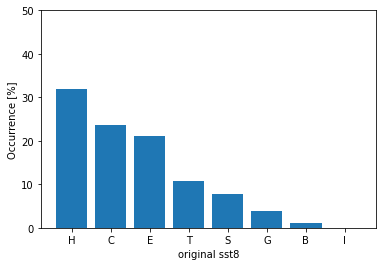

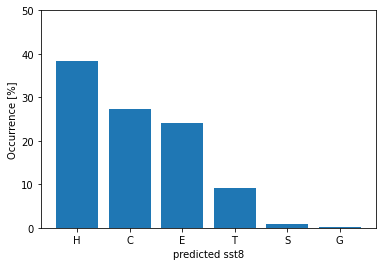

In [54]:
visualizer.visualize_occurrence(feature_series=sst8_model_eval_df.original_sst8, xlabel='original sst8').show()
visualizer.visualize_occurrence(feature_series=sst8_model_eval_df.predicted_sst8_test, xlabel='predicted sst8').show()

#### Comparison of the distribution of particular secondary structure elements indicates, that the overall trend of the prediction is maintained for six most frequent secondary structure types. Nevertheless, one can observe lack of the assignment of B and I stucture and relatively underestimated assignment of S and G, while H, C and E were relatively more frequently occuring in predicted structures (lower plot) compared to original structures (upper plot)

In [116]:
sst8_model_eval_df.correctly_assigned.mean().round(2)

0.59

#### Investigaton of the corresponding original and predicted secondary structure elements in terms proper classification indicates that on average __59%__ of the positions was predicted correctly in the test set, reaching lower success compared to Q3 prediction as expected (due to higher complexity)

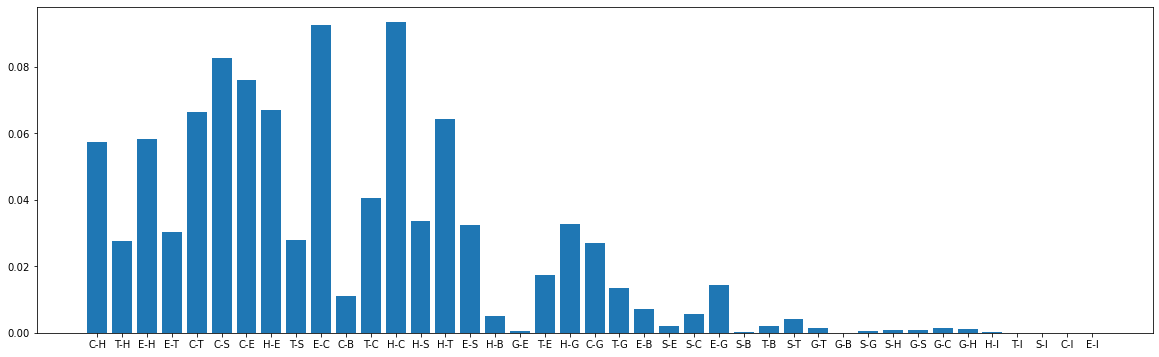

In [121]:
sst8_mistakes_summary = dict(Counter(list(itertools.chain.from_iterable(sst8_model_eval_df.mistakes.values.tolist()))))
plt.figure(figsize=(20,6))
plt.bar(x=np.arange(len(sst8_mistakes_summary)), height=[x/sum(sst8_mistakes_summary.values()) for x in sst8_mistakes_summary.values()]) 
plt.xticks(ticks=np.arange(len(sst8_mistakes_summary)), labels=sst8_mistakes_summary.keys())
plt.show()

#### Further analysis suggests that three the most frequently occuring errors in the Q8 secondary structure predictions are assignment of helix instead of coil (H-C), extended conformation instead of coil (E-C) and coil instead of S, which is type of coil structure (C-S).

##### __Q8 best predictions__

In [66]:
sst8_model_eval_df[sst8_model_eval_df.correctly_assigned == sst8_model_eval_df.correctly_assigned.max()]

,original_sst8,predicted_sst8_test,correctly_assigned,mistakes
1662,CCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCC,CCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCCC,0.972222,[C-H]


##### __Q8 worst predictions__

In [69]:
sst8_model_eval_df[sst8_model_eval_df.correctly_assigned == sst8_model_eval_df.correctly_assigned.min()].values

array([['CCEEEEEECTTTSSECSEEEC', 'CCCCCCCCCCCCCCCEEECCC',
        0.23809523809523808,
        list(['C-E', 'C-E', 'C-E', 'C-E', 'C-E', 'C-E', 'C-T', 'C-T', 'C-T', 'C-S', 'C-S', 'C-E', 'E-C', 'E-S', 'C-E', 'C-E'])]],
      dtype=object)

## __10. Summary__

#### While building a model, with increasing complexity of the network I was gradually gaining improved categorical accuracy for the Q3 protein secondary structure prediction with the lowest score for the model1 (LSTM with self-defined embedding) and the best score for the model8 (Conv1d + 2x BiLSTM + 2x Dense + protvec embeddings). I hypothesize, that increasing the complexity of the networks may still improve the predictions, as indicated in the literature (2) but due to the time constraints on the project preparation and limited computational resources I have limited the complexity of the models up to model8-level complexity. The Q8 secondary structure prediciton using model9 being analogous variant of model8 reached lower categorical accuaracy due to significantly more complex and difficult task as compared to Q3 prediction (8). 

#### Furthermore, model8 (Q3 prediction) on average predicted around 71% positions correctly, while model9 (Q9) exhibited 59% of correctly assigned secondary structure types, which indicates need for further improvements of the model to gain more reliable predicitions. One of the solutions could be to continue expanding the complexity of the model as mentioned above. On the other hand, as implemented by psnjiki in (9), another custom metric could be used while building a model which could result in improved final performance of the model and better ratio of correctly assigned secondary structure types either in Q3 or Q8 predictions.

#### Overall, although the model is not perfect, it is worth noting that it is build on the real and up-to-date PDB and PISCES dataset and aims at generally non-trivial task, hence the initial results obtained in this project are interesting and constitute promising start for potential in-dept investigation and optimization.

## __11. References__

1. https://www.dnastar.com/blog/structural-biology/why-structure-prediction-matters/

2. Yang Y, Gao J, Wang J, Heffernan R, Hanson J, Paliwal K, Zhou Y. Sixty-five years of the long march in protein secondary structure prediction: the final stretch? Brief Bioinform. 2018 May 1;19(3):482-494. doi: 10.1093/bib/bbw129. PMID: 28040746; PMCID: PMC5952956. https://pubmed.ncbi.nlm.nih.gov/28040746/

3. Asgari E, Mofrad MRK (2015) Continuous Distributed Representation of Biological Sequences for Deep Proteomics and Genomics. PLOS ONE 10(11): e0141287. https://doi.org/10.1371/journal.pone.0141287

4. https://www.kaggle.com/alfrandom/protein-secondary-structure

5. https://github.com/zyxue/pdb-secondary-structure

6. http://dunbrack.fccc.edu/Guoli/pisces_download.php

7. J. Chem. Inf. Model. 2020, 60, 6, 2773–2790 https://doi.org/10.1021/acs.jcim.0c00073

8. Zhang, B., Li, J. & Lü, Q. Prediction of 8-state protein secondary structures by a novel deep learning architecture. BMC Bioinformatics 19, 293 (2018). https://doi.org/10.1186/s12859-018-2280-5

9. https://gist.github.com/psnjiki/9b668e185a2d27aeb9602e92653e9741
